In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split



## 数据预处理

In [2]:
def advanced_preprocessing(df, target_col='plan_type'):
    """
    高级数据预处理函数 - 区分有序变量和名义变量
    """
    data = df.copy()
    
    print("开始高级数据预处理...")
    print(f"原始数据形状: {data.shape}")
    
    # 1. 删除无关特征
    if 'person_id' in data.columns:
        data = data.drop('person_id', axis=1)
        print("已删除 person_id 列")
    
    # 2. 处理缺失值
    missing_cols = data.columns[data.isnull().any()].tolist()
    print(f"\n有缺失值的列: {missing_cols}")
    
    for col in missing_cols:
        if data[col].dtype == 'object':
            mode_val = data[col].mode()[0]
            data[col].fillna(mode_val, inplace=True)
            print(f"分类特征 '{col}' 用众数 '{mode_val}' 填充")
        else:
            median_val = data[col].median()
            data[col].fillna(median_val, inplace=True)
            print(f"数值特征 '{col}' 用中位数 {median_val} 填充")
    
    # 3. 定义编码策略
    ordinal_features = {
        'education': ['No HS', 'HS', 'Some College', 'Bachelors', 'Masters', 'Doctorate'],
        'smoker': ['Never', 'Former', 'Current'],
        'alcohol_freq': ['Occasional', 'Weekly', 'Daily'], 
        'network_tier': ['Bronze', 'Silver', 'Gold', 'Platinum']
    }
    
    # 名义变量（无序分类变量）
    nominal_features = ['sex', 'region', 'urban_rural', 'marital_status', 'employment_status']
    
    # 4. 分离特征和目标变量
    X = data.drop(target_col, axis=1)
    y = data[target_col]
    
    # 5. 识别数值特征
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # 从数值特征中移除已经在有序/名义变量中定义的特征
    numerical_cols = [col for col in numerical_cols if col not in ordinal_features and col not in nominal_features]
    
    print(f"\n特征类型分布:")
    print(f"  有序变量: {len(ordinal_features)}个 - {list(ordinal_features.keys())}")
    print(f"  名义变量: {len(nominal_features)}个 - {nominal_features}")
    print(f"  数值特征: {len(numerical_cols)}个")
    print(f"  目标变量: 1个 - {target_col}")
    
    # 6. 有序变量编码
    print(f"\n=== 有序变量编码 ===")
    ordinal_encoder = OrdinalEncoder(
        categories=[ordinal_features[feat] for feat in ordinal_features.keys()], 
        dtype=np.int64
    )
    
    # 检查并处理有序变量中可能缺失的类别
    for feat in ordinal_features.keys():
        unique_vals = set(X[feat].unique())
        expected_vals = set(ordinal_features[feat])
        missing_in_data = expected_vals - unique_vals
        if missing_in_data:
            print(f"  警告: {feat} 缺少类别: {missing_in_data}")
    
    X[list(ordinal_features.keys())] = ordinal_encoder.fit_transform(X[list(ordinal_features.keys())])
    
    for feat in ordinal_features.keys():
        print(f"  {feat}: {ordinal_features[feat]} -> 编码为 0-{len(ordinal_features[feat])-1}")
    
    # 7. 名义变量独热编码
    print(f"\n=== 名义变量独热编码 ===")
    # 先创建副本，避免SettingWithCopyWarning
    X_encoded = X.copy()
    
    # 对每个名义变量进行独热编码
    for col in nominal_features:
        dummies = pd.get_dummies(X[col], prefix=col, drop_first=True, dtype=np.int64)
        X_encoded = pd.concat([X_encoded, dummies], axis=1)
        X_encoded = X_encoded.drop(col, axis=1)
        print(f"  {col}: 创建了 {dummies.shape[1]} 个虚拟变量")
    
    # # 8. 标准化数值特征
    # print(f"\n=== 数值特征标准化 ===")
    # scaler = StandardScaler()
    # X_encoded[numerical_cols] = scaler.fit_transform(X_encoded[numerical_cols])
    # print(f"  标准化了 {len(numerical_cols)} 个数值特征")
    
    # 9. 编码目标变量
    print(f"\n=== 目标变量编码 ===")
    # 目标变量作为名义变量处理，使用LabelEncoder
    from sklearn.preprocessing import LabelEncoder
    le_target = LabelEncoder()
    y_encoded = le_target.fit_transform(y)
    
    print(f"  目标变量 '{target_col}' 编码完成: {len(le_target.classes_)} 个类别")
    print(f"  类别分布: {dict(zip(le_target.classes_, np.bincount(y_encoded)))}")
    
    # 10. 最终数据检查
    print(f"\n=== 最终数据检查 ===")
    print(f"  最终特征数量: {X_encoded.shape[1]}")
    print(f"  样本数量: {X_encoded.shape[0]}")
    
    # 检查是否有object类型剩余
    remaining_object_cols = X_encoded.select_dtypes(include=['object']).columns.tolist()
    if remaining_object_cols:
        print(f"  警告: 仍有object类型特征: {remaining_object_cols}")
    else:
        print(f" 所有特征都已正确编码，无object类型剩余")
    
    # 返回所有预处理组件
    preprocessing_info = {
        'ordinal_features': ordinal_features,
        'nominal_features': nominal_features,
        'numerical_cols': numerical_cols,
        'ordinal_encoder': ordinal_encoder,
        # 'scaler': scaler,
        'le_target': le_target
    }
    
    return X_encoded, y_encoded, preprocessing_info

# 执行高级预处理
df = pd.read_csv('medical_insurance.csv')
df = df[df['age'] > 20]  # 删除异常数据
X_advanced, y_advanced, preprocess_info = advanced_preprocessing(df)
y_advanced = pd.Series(y_advanced, name='plan_type')


开始高级数据预处理...
原始数据形状: (95394, 54)
已删除 person_id 列

有缺失值的列: ['alcohol_freq']
分类特征 'alcohol_freq' 用众数 'Occasional' 填充

特征类型分布:
  有序变量: 4个 - ['education', 'smoker', 'alcohol_freq', 'network_tier']
  名义变量: 5个 - ['sex', 'region', 'urban_rural', 'marital_status', 'employment_status']
  数值特征: 43个
  目标变量: 1个 - plan_type

=== 有序变量编码 ===
  education: ['No HS', 'HS', 'Some College', 'Bachelors', 'Masters', 'Doctorate'] -> 编码为 0-5
  smoker: ['Never', 'Former', 'Current'] -> 编码为 0-2
  alcohol_freq: ['Occasional', 'Weekly', 'Daily'] -> 编码为 0-2
  network_tier: ['Bronze', 'Silver', 'Gold', 'Platinum'] -> 编码为 0-3

=== 名义变量独热编码 ===
  sex: 创建了 2 个虚拟变量
  region: 创建了 4 个虚拟变量
  urban_rural: 创建了 2 个虚拟变量
  marital_status: 创建了 3 个虚拟变量
  employment_status: 创建了 3 个虚拟变量

=== 目标变量编码 ===
  目标变量 'plan_type' 编码完成: 4 个类别
  类别分布: {'EPO': 14489, 'HMO': 33088, 'POS': 14291, 'PPO': 33526}

=== 最终数据检查 ===
  最终特征数量: 61
  样本数量: 95394
 所有特征都已正确编码，无object类型剩余


### 相关系数描述

In [9]:
data = pd.read_csv("insurance_data_preprocessed.csv")


In [11]:
X = data.drop('is_high_risk',axis=1)
y = data['is_high_risk']

Feature correlations with is_high_risk (sorted):
risk_score                0.828491
chronic_count             0.571784
age                       0.557669
systolic_bp               0.429379
diastolic_bp              0.299937
                            ...   
urban_rural_Urban        -0.003796
region_South             -0.003906
marital_status_Widowed   -0.004420
education                -0.005107
marital_status_Single    -0.005555
Length: 63, dtype: float64


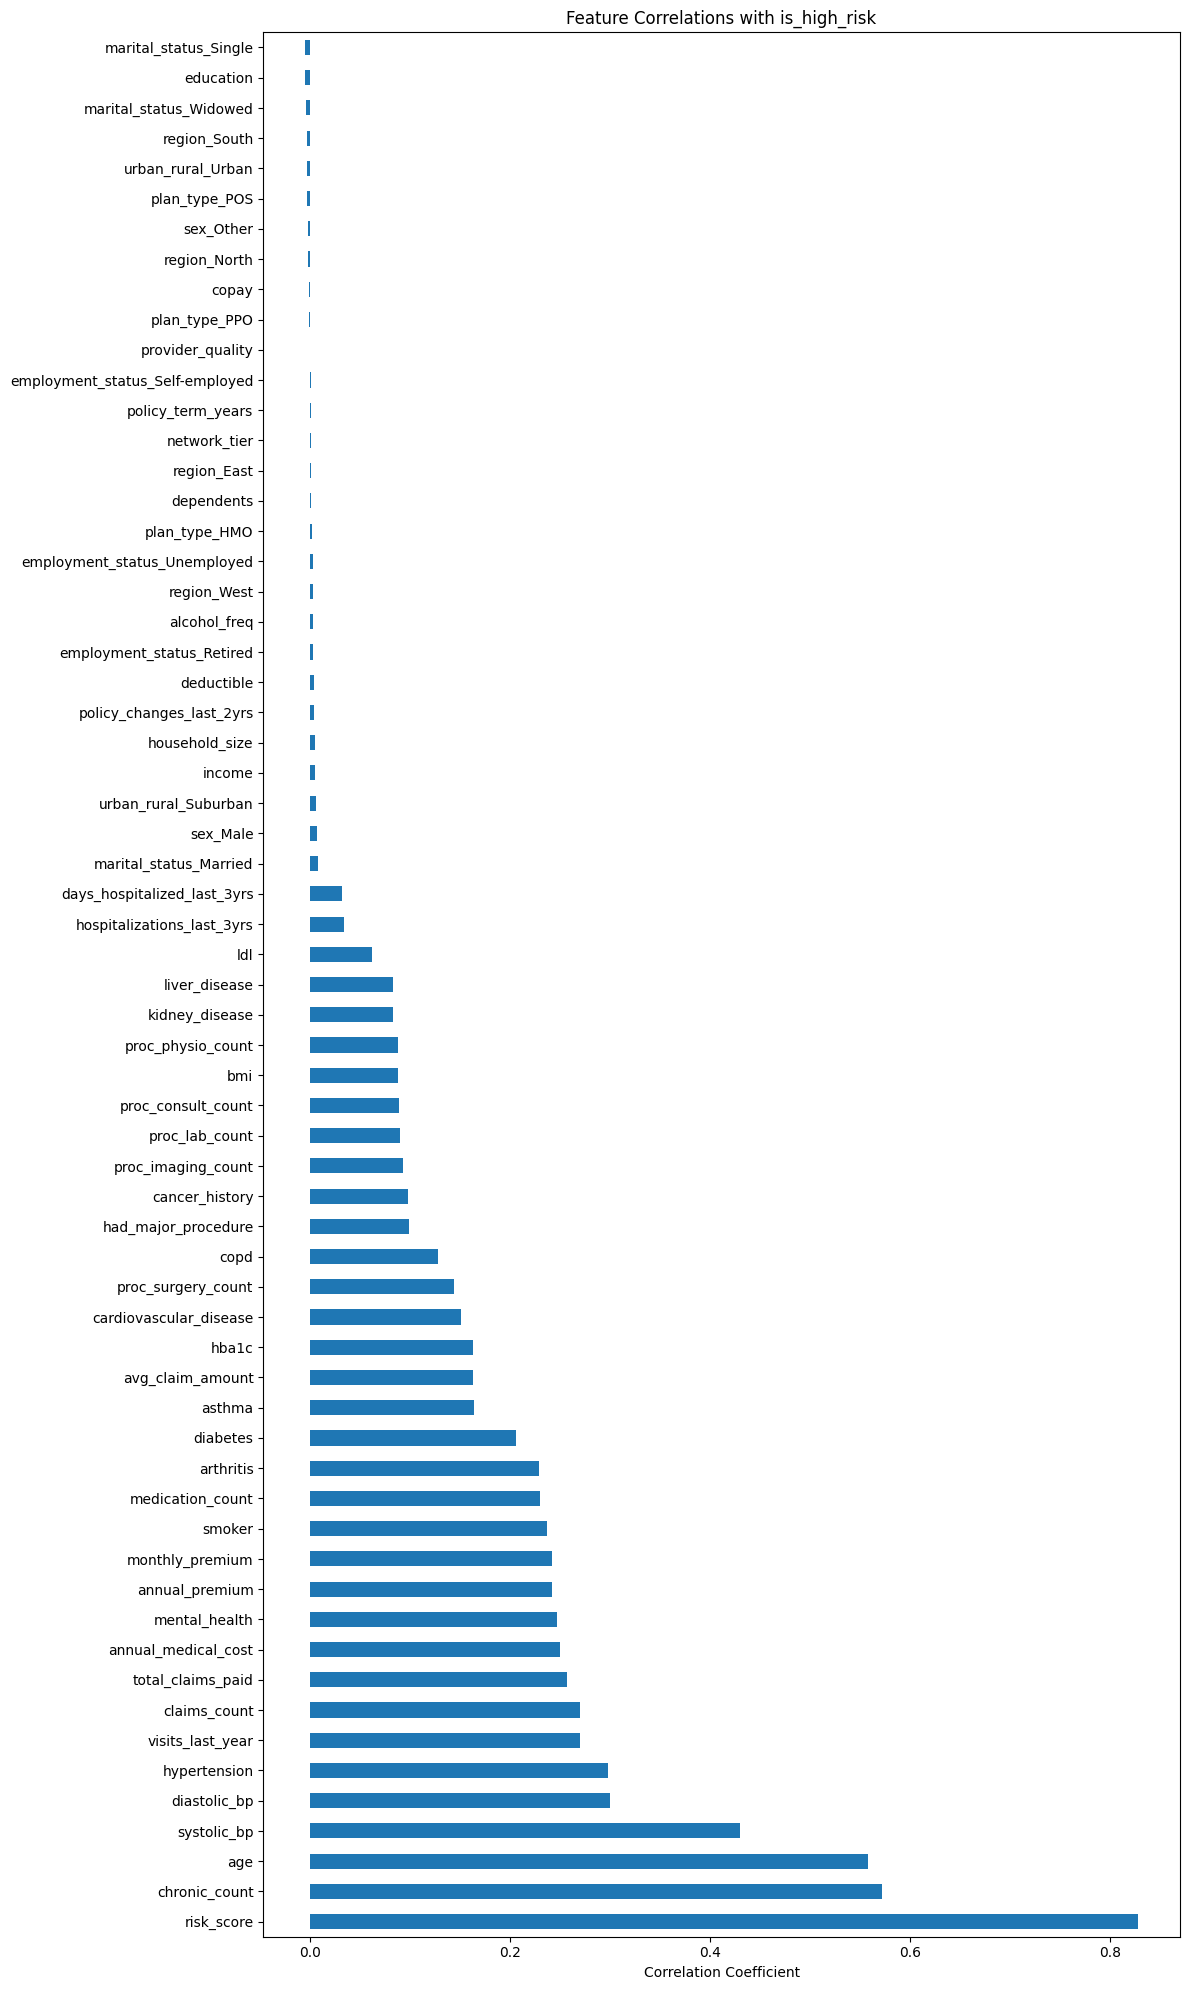

In [12]:
y = pd.Series(y, name='plan_type')

# Calculate correlation between all features and target variable
correlation_with_target = X.corrwith(y).sort_values(ascending=False)

print("Feature correlations with is_high_risk (sorted):")
print(correlation_with_target)

# Plot correlation bar chart
plt.figure(figsize=(12, 20))
correlation_with_target.plot(kind='barh')
plt.title('Feature Correlations with is_high_risk')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()


## 分类模型

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import time
import seaborn as sns
# 准备分类模型
classification_models = {
    # "Logistic Regression": LogisticRegression(random_state=42),  # 逻辑回归
    # "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5, n_jobs=1),  # K近邻
    "Decision_Tree_Classifier": DecisionTreeClassifier(random_state=42),  # 决策树分类
    "Random Forest Classifier": RandomForestClassifier(random_state=42),  # 随机森林分类
    "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=42),  # 梯度提升分类
    "MLP_Classifier_1": MLPClassifier(hidden_layer_sizes=(50, 25), activation='relu', 
                                   solver='adam', batch_size=32, max_iter=1000, random_state=42),  # 前馈神经网络分类
    "MLP_Classifier_2": MLPClassifier(hidden_layer_sizes=(50, 50, 50, 50), activation='relu', 
                                   solver='adam', batch_size=32, max_iter=1000, random_state=42)  # 前馈神经网络分类
}

In [ ]:

def classification_train(X_train, X_test, y_train, y_test, models):
    n_models = len(models)
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    if n_models == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for idx, (name, model) in enumerate(models.items()):
        time_start = time.time()
        
        # 训练模型
        model.fit(X_train, y_train)
        
        # 训练集预测
        y_train_pred = model.predict(X_train)
        
        # 测试集预测
        y_test_pred = model.predict(X_test)
        
        # 计算评估指标 - 训练集
        accuracy_train = accuracy_score(y_train, y_train_pred)
        precision_train = precision_score(y_train, y_train_pred, average='weighted', zero_division=0)
        recall_train = recall_score(y_train, y_train_pred, average='weighted', zero_division=0)
        f1_train = f1_score(y_train, y_train_pred, average='weighted', zero_division=0)
        
        # 计算评估指标 - 测试集
        accuracy_test = accuracy_score(y_test, y_test_pred)
        precision_test = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
        recall_test = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
        f1_test = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
        
        # 绘制混淆矩阵
        ax = axes[idx]
        cm = confusion_matrix(y_test, y_test_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title(f'{name} Test Accuracy: {accuracy_test:.3f}')
        
        print("Model:", name)
        print("模型在训练集上的评估结果：")
        print(f"Accuracy: {accuracy_train:.4f}")
        print(f"Precision: {precision_train:.4f}")
        print(f"Recall: {recall_train:.4f}")
        print(f"F1-Score: {f1_train:.4f}")
        print()
        
        print("模型在测试集上的评估结果：")
        print(f"Accuracy: {accuracy_test:.4f}")
        print(f"Precision: {precision_test:.4f}")
        print(f"Recall: {recall_test:.4f}")
        print(f"F1-Score: {f1_test:.4f}")
        print('-'*50)
        
        # 显示详细分类报告
        print("详细分类报告：")
        print(classification_report(y_test, y_test_pred, zero_division=0))
        
        time_end = time.time()
        print(f"训练时间: {time_end - time_start:.2f}秒")
        print()

    # 隐藏多余的子图
    for idx in range(len(models), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle('Confusion Matrix in all model', fontsize=16, y=1.02)
    plt.show()

In [13]:
test_size = 0.8
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=test_size,
                                                    random_state=42, stratify=y)

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)  # 使用训练集的参数来转换测试集

Classification Models Evaluation:
Model: Decision_Tree_Classifier
模型在训练集上的评估结果：
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

模型在测试集上的评估结果：
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
--------------------------------------------------
详细分类报告：
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46967
           1       1.00      1.00      1.00     29349

    accuracy                           1.00     76316
   macro avg       1.00      1.00      1.00     76316
weighted avg       1.00      1.00      1.00     76316

训练时间: 0.35秒

Model: Random Forest Classifier
模型在训练集上的评估结果：
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

模型在测试集上的评估结果：
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
--------------------------------------------------
详细分类报告：
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46967
         

c:\Users\A208-7\.conda\envs\fealpy_env\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25152 (\N{CJK UNIFIED IDEOGRAPH-6240}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\A208-7\.conda\envs\fealpy_env\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26377 (\N{CJK UNIFIED IDEOGRAPH-6709}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\A208-7\.conda\envs\fealpy_env\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\A208-7\.conda\envs\fealpy_env\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\A208-7\.conda\envs\fealpy_env\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 

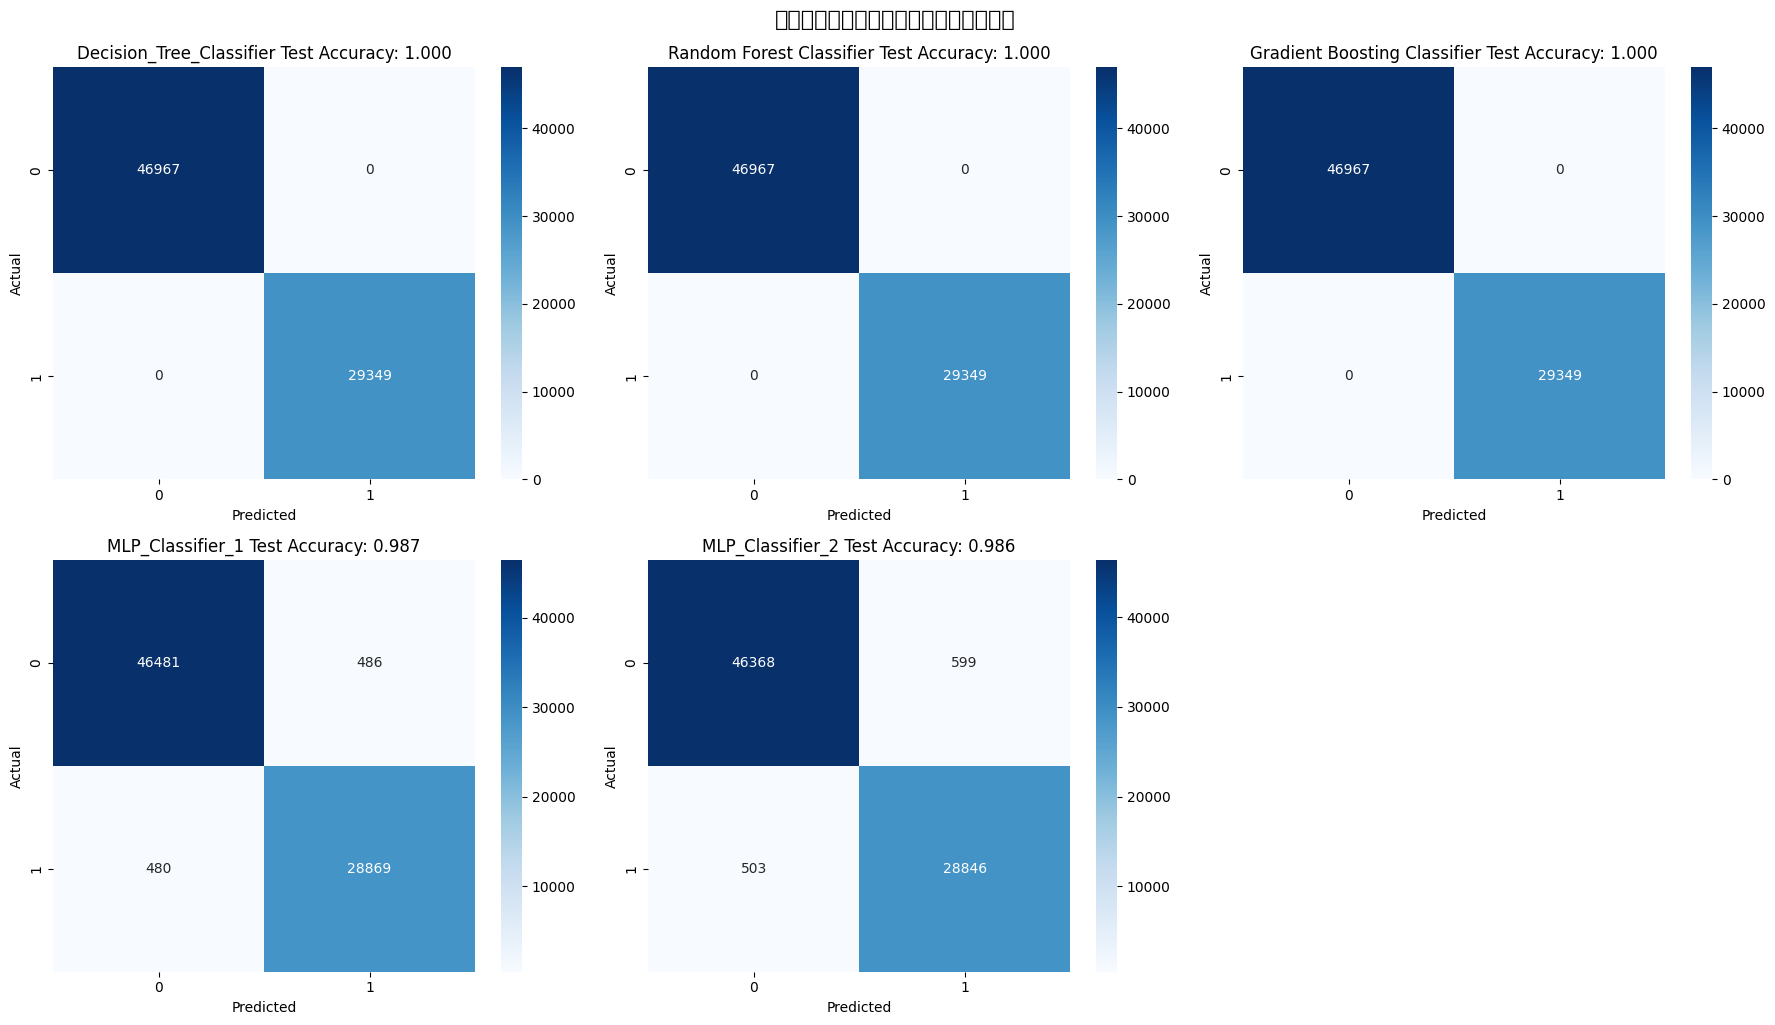

In [14]:
# 使用示例
print("Classification Models Evaluation:")
flag_standard_classification = True  # 是否标准化特征
if flag_standard_classification:
    scaler = StandardScaler()
    X_train_class = scaler.fit_transform(X_train)
    X_test_class = scaler.transform(X_test)

classification_train(X_train=X_train_class, X_test=X_test_class, y_train=y_train, y_test=y_test, models=classification_models)

## 评价保险公司是否赔钱